In [2]:
import pandas as pd
import re
import string
import emoji
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from pandarallel import pandarallel


In [4]:
# Setting visualisasi
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# Load dataset
df = pd.read_csv('hasil_labelling_final_filtered.csv')
print(f" Dataset loaded: {len(df)} rows")
df

 Dataset loaded: 9795 rows


,text,tokoh,prediksi_label_raw,score_keyakinan,label_final
0,Pembantu mu banyak yg rusak paak,Purbaya Yudhi Sadewa,negative,0.999369,Negatif
1,Ia pa benar pasl 33 skarang pengusaha suasta s...,Purbaya Yudhi Sadewa,negative,0.999472,Negatif
2,"Jangan Angguk angguk aja, Mentri Kehutanan,Lih...",Purbaya Yudhi Sadewa,negative,0.999365,Negatif
3,Susah di pecat kalau menterinya ketum parpol,Purbaya Yudhi Sadewa,negative,0.996516,Negatif
4,Kerusakan lingkungan tidak akan terjadi kalau ...,Purbaya Yudhi Sadewa,negative,0.999033,Negatif
...,...,...,...,...,...
9790,RUANG FISKAL TIDAK ADA KRN PEMERINTAH SUDAH BE...,Sri Mulyani Indrawati,negative,0.992726,Negatif
9791,"Bubarkan DPR sd korupsi mkn gaji buta lagi, sa...",Sri Mulyani Indrawati,negative,0.998874,Negatif
9792,Kalau memang uang negara belum cukup tuk ASN k...,Sri Mulyani Indrawati,negative,0.928499,Negatif
9793,"Prabowo mengutamakan para pejabat,kasian pk,pr...",Sri Mulyani Indrawati,negative,0.997244,Negatif


In [5]:
# Inisialisasi Parallel Processing
pandarallel.initialize(progress_bar=True, nb_workers=4)

# Cek GPU
if torch.cuda.is_available():
    print(f"✅ GPU Terdeteksi: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ GPU tidak terdeteksi")

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/
⚠️ GPU tidak terdeteksi


In [6]:
# ============================================
# CELL 4: EMOJI MAPPING (TRANSLATE KE BAHASA INDONESIA)
# ============================================

# Mapping emoji bahasa Inggris -> Bahasa Indonesia
emoji_map_indo = {
    # Emoji Positif
    "thumbs_up": "jempol",
    "OK_hand": "oke",
    "clapping_hands": "tepuk_tangan",
    "folded_hands": "terima_kasih",
    "red_heart": "cinta",
    "fire": "keren",
    "star": "bintang",
    "check_mark": "benar",

    # Emoji Tertawa
    "face_with_tears_of_joy": "tertawa",
    "rolling_on_the_floor_laughing": "tertawa",
    "grinning_face": "senang",
    "beaming_face_with_smiling_eyes": "senang",
    "smiling_face_with_smiling_eyes": "senang",
    "grinning_face_with_smiling_eyes": "senang",
    "face_savoring_food": "enak",

    # Emoji Sedih/Negatif
    "loudly_crying_face": "menangis",
    "crying_face": "sedih",
    "disappointed_face": "kecewa",
    "pensive_face": "khawatir",
    "weary_face": "lelah",
    "tired_face": "capek",

    # Emoji Marah
    "face_with_symbols_on_mouth": "marah",
    "angry_face": "marah",
    "pouting_face": "kesal",
    "face_with_steam_from_nose": "dongkol",

    # Emoji Thinking
    "thinking_face": "berpikir",
    "person_shrugging": "tidak_tahu",
    "confused_face": "bingung",

    # Emoji Lainnya
    "face_screaming_in_fear": "takut",
    "anxious_face_with_sweat": "cemas",
    "eyes": "melihat",
    "raised_fist": "semangat",
}

# Emoji yang mengindikasikan sentimen (untuk fitur tambahan)
emoji_sentiment_positive = {
    'tertawa', 'senang', 'cinta', 'keren', 'jempol',
    'oke', 'tepuk_tangan', 'terima_kasih', 'semangat'
}

emoji_sentiment_negative = {
    'menangis', 'sedih', 'kecewa', 'marah', 'kesal',
    'dongkol', 'takut', 'cemas', 'khawatir'
}

emoji_sentiment_neutral = {
    'berpikir', 'tidak_tahu', 'bingung', 'melihat'
}

In [7]:
# ============================================
# CELL 5: SETUP DICTIONARY & STOPWORDS
# ============================================

# --- 1. NORMALISASI DICTIONARY ---
normalisasi_dict = {
    # Kata dasar
    "yg": "yang", "gk": "tidak", "gak": "tidak", "ga": "tidak",
    "kalo": "kalau", "klo": "kalau", "kyk": "kayak",
    "wkwk": "", "wkwkwk": "", "wk": "", "haha": "", "hihi": "",
    "paak": "pak", "pa": "pak", "bpk": "bapak",
    "smisal": "semisal", "byak": "banyak", "dgn": "dengan",
    "sdh": "sudah", "aja": "saja", "bgt": "banget",
    "asikkk": "asik", "sip": "siap", "ok": "oke",
    "bahlul": "bodoh", "lemot": "lambat", "lot": "lambat",
    "copot": "pecat", "suasta": "swasta",
    "pasl": "pasal", "menjawaydan": "menjawab",

    # Kata domain spesifik
    "mentri": "menteri", "menkeu": "menteri_keuangan",
    "pemerintahan": "pemerintah", "pemimpin": "pimpinan",
    "kebijaksanaan": "kebijakan", "anggaran": "anggaran",
    "rakyat": "rakyat", "negara": "negara",
}

# --- 2. WHITELIST: NAMA TOKOH ---
protected_words = {
    'sri', 'mulyani', 'purbaya', 'yudhi', 'sadewa',
    'indrawati', 'jokowi', 'prabowo', 'presiden', 'menteri'
}

# --- 3. NEGATION WORDS ---
negation_words = {
    'tidak', 'tak', 'bukan', 'jangan', 'belum',
    'tanpa', 'kurang', 'minim', 'gagal'
}

# --- 4. CUSTOM STOPWORDS ---
custom_stopwords_raw = [
    "dan", "yang", "di", "ke", "dari", "ini", "itu", "adalah",
    "yg", "dg", "rt", "dgn", "ny", "klo", "kalo", "amp",
    "biar", "bikin", "bilang", "krn", "nya", "nih", "sih",
    "si", "tau", "tuh", "utk", "ya", "jd", "sdh", "aja",
    "nan", "loh", "pen", "ada", "akan", "untuk",
    "pada", "atau", "juga", "saat", "bisa", "sudah",
    "sangat", "harus", "saja", "oleh", "karena", "jika"
]

# --- 5. GABUNGKAN STOPWORDS ---
factory_sw = StopWordRemoverFactory()
stopwords_sastrawi = set(factory_sw.get_stop_words())

final_stopwords = (
    stopwords_sastrawi |
    set(custom_stopwords_raw)
) - (negation_words | protected_words)

print(f"✅ Total stopwords: {len(final_stopwords)}")
print(f"✅ Protected words: {protected_words}")


✅ Total stopwords: 146
✅ Protected words: {'mulyani', 'jokowi', 'indrawati', 'sri', 'sadewa', 'yudhi', 'prabowo', 'purbaya', 'menteri', 'presiden'}


In [8]:
# ============================================
# CELL 6: FUNGSI EKSTRAKSI & TRANSLATE EMOJI
# ============================================

def extract_and_translate_emoji(text):
    """
    Ekstrak emoji dari text dan translate ke Bahasa Indonesia

    Returns:
        tuple: (emoji_list, emoji_sentiment_score)
    """
    if not isinstance(text, str):
        return [], 0

    # Ekstrak semua emoji dari text
    emoji_list = []
    sentiment_score = 0

    # Demojize untuk dapat nama emoji dalam bahasa Inggris
    demojized = emoji.demojize(text, delimiters=(":", ":"))

    # Cari semua emoji pattern :nama_emoji:
    emoji_patterns = re.findall(r':([a-zA-Z_]+):', demojized)

    for emoji_name in emoji_patterns:
        # Translate ke Bahasa Indonesia jika ada di mapping
        if emoji_name in emoji_map_indo:
            indo_name = emoji_map_indo[emoji_name]
            emoji_list.append(indo_name)

            # Hitung sentiment score dari emoji
            if indo_name in emoji_sentiment_positive:
                sentiment_score += 1
            elif indo_name in emoji_sentiment_negative:
                sentiment_score -= 1

    return emoji_list, sentiment_score

In [9]:
# ============================================
# CELL 7: FUNGSI PREPROCESSING (2 VERSI)
# ============================================

# Inisialisasi Stemmer
factory_stem = StemmerFactory()
stemmer = factory_stem.create_stemmer()

def preprocess_text(text, use_stemming=False, keep_emoji=False):
    """
    Preprocessing text dengan 2 mode:
    - keep_emoji=True: Untuk dokumentasi (emoji ditranslate jadi kata Indo)
    - keep_emoji=False: Untuk visualisasi (emoji dihapus)

    Args:
        text: Input text
        use_stemming: Aktifkan stemming
        keep_emoji: Pertahankan hasil translate emoji
    """
    if not isinstance(text, str) or text.strip() == "":
        return ""

    # 1. LOWERCASE
    text = text.lower()

    # 2. TRANSLATE EMOJI (jika keep_emoji=True)
    if keep_emoji:
        # Demojize dulu
        text = emoji.demojize(text, delimiters=(" ", " "))

        # Replace dengan Bahasa Indonesia
        for eng_name, indo_name in emoji_map_indo.items():
            text = text.replace(eng_name, indo_name)

        # Hapus emoji yang tidak termapping (sisa :xxx:)
        text = re.sub(r':[a-zA-Z_]+:', '', text)
    else:
        # HAPUS EMOJI LANGSUNG (untuk visualisasi)
        text = emoji.replace_emoji(text, replace='')

    # 3. HAPUS URL & MENTION
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)

    # 4. HAPUS ANGKA
    text = re.sub(r'\d+', '', text)

    # 5. HAPUS TANDA BACA
    text = text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))

    # 6. HAPUS KARAKTER BERULANG
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # 7. NORMALISASI WHITESPACE
    text = re.sub(r'\s+', ' ', text).strip()

    # 8. SPLIT & CLEAN WORDS
    words = text.split()
    clean_words = []

    for word in words:
        if not word:
            continue

        # Normalisasi
        if word in normalisasi_dict:
            word = normalisasi_dict[word]
            if word == "":
                continue

        # Skip stopwords
        if word in final_stopwords:
            continue

        # Skip kata < 3 huruf (kecuali protected & negation)
        if len(word) < 3:
            if word not in protected_words and word not in negation_words:
                continue

        # Stemming
        if use_stemming:
            if word not in protected_words and word not in negation_words:
                word = stemmer.stem(word)

        clean_words.append(word)

    return " ".join(clean_words)


In [12]:
%pip install ipywidgets

  Using cached ipywidgets-8.1.8-py3-none-any.whl (139 kB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\alfit\Documents\Duty Script\Kuliah\Semester 7\Pemrosesan Teks\Mini_project\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [ ]:
# ============================================
# CELL 8: EKSEKUSI PREPROCESSING (4 KOLOM)
# ============================================
# ============================================
# CELL 8: PERBAIKAN (Solusi NameError 'pd')
# ============================================

# Pastikan fungsi ini mengembalikan list/tuple, contoh: [list_emoji, score_sentiment]
# Hapus penggunaan pd.Series di dalam lambda

print("1️⃣ Ekstraksi Emoji...")

# Langkah A: Biarkan worker hanya mengembalikan List/Tuple (Worker tidak perlu kenal 'pd')
temp_emoji_data = df['text'].parallel_apply(extract_and_translate_emoji)

# Langkah B: Konversi hasilnya menjadi kolom DataFrame di Main Process (dimana 'pd' dikenal)
# Kita gunakan tolist() untuk mengubah Series of Lists menjadi List of Lists agar bisa jadi DataFrame
df[['emoji_list', 'emoji_sentiment']] = pd.DataFrame(
    temp_emoji_data.tolist(), index=df.index)

# -----------------------------------------------------------
# SISA CODE (Langkah 2, 3, 4 aman karena tidak memanggil 'pd' di dalam lambda)
# -----------------------------------------------------------

# 2. Clean text TANPA emoji
print("2️⃣ Cleaning TANPA Emoji (untuk WordCloud & N-Gram)...")
df['clean_no_emoji'] = df['text'].parallel_apply(
    lambda x: preprocess_text(x, use_stemming=False, keep_emoji=False)
)

# 3. Clean text DENGAN emoji translated
print("3️⃣ Cleaning DENGAN Emoji Translated (untuk dokumentasi)...")
df['clean_with_emoji'] = df['text'].parallel_apply(
    lambda x: preprocess_text(x, use_stemming=False, keep_emoji=True)
)

# 4. Clean text dengan stemming
print("4️⃣ Cleaning + Stemming (untuk modeling)...")
df['clean_stemmed'] = df['text'].parallel_apply(
    lambda x: preprocess_text(x, use_stemming=True, keep_emoji=False)
)

# Hapus baris kosong
df = df[df['clean_no_emoji'].str.strip() != '']

print("\n✅ Preprocessing Selesai!")
print(f"📊 Data tersisa: {len(df)} rows")

🔄 Memproses Data...
1️⃣ Ekstraksi Emoji...


NameError: name 'pd' is not defined

In [ ]:
# ============================================
# CELL 9: TAMPILKAN HASIL PERBANDINGAN
# ============================================
print("\n" + "=" * 80)
print("PERBANDINGAN HASIL PREPROCESSING:")
print("=" * 80)

sample_df = df[['text', 'emoji_list', 'emoji_sentiment',
                'clean_with_emoji', 'clean_no_emoji', 'clean_stemmed']].head(10)

pd.set_option('display.max_colwidth', 50)
print(sample_df)
pd.reset_option('display.max_colwidth')

# Statistik Emoji
print("\n📊 STATISTIK EMOJI:")
print("=" * 60)
print(f"Total tweets dengan emoji: {df['emoji_list'].apply(len).gt(0).sum()}")
print(f"Rata-rata emoji per tweet: {df['emoji_list'].apply(len).mean():.2f}")
print(f"\nDistribusi Emoji Sentiment Score:")
print(df['emoji_sentiment'].value_counts().sort_index())


PERBANDINGAN HASIL PREPROCESSING:
                                                text  \
0                   Pembantu mu banyak yg rusak paak   
1  Ia pa benar pasl 33 skarang pengusaha suasta s...   
2  Jangan Angguk angguk aja, Mentri Kehutanan,Lih...   
3       Susah di pecat kalau menterinya ketum parpol   
4  Kerusakan lingkungan tidak akan terjadi kalau ...   
5                             Menteri nakal di piara   
6  Fakta nya masih di nikmati oleh kaum kaum elit...   
7  Wkwkwk  jangankan menterinya, elu sendiri aja ...   
8                      Copot saja menteri yang lemot   
9  TUYUL IRENG BAHLIL ngapain duduk disana bareng...   

                                          emoji_list  emoji_sentiment  \
0                                                 []                0   
1                                                 []                0   
2                                                 []                0   
3                                                 []    

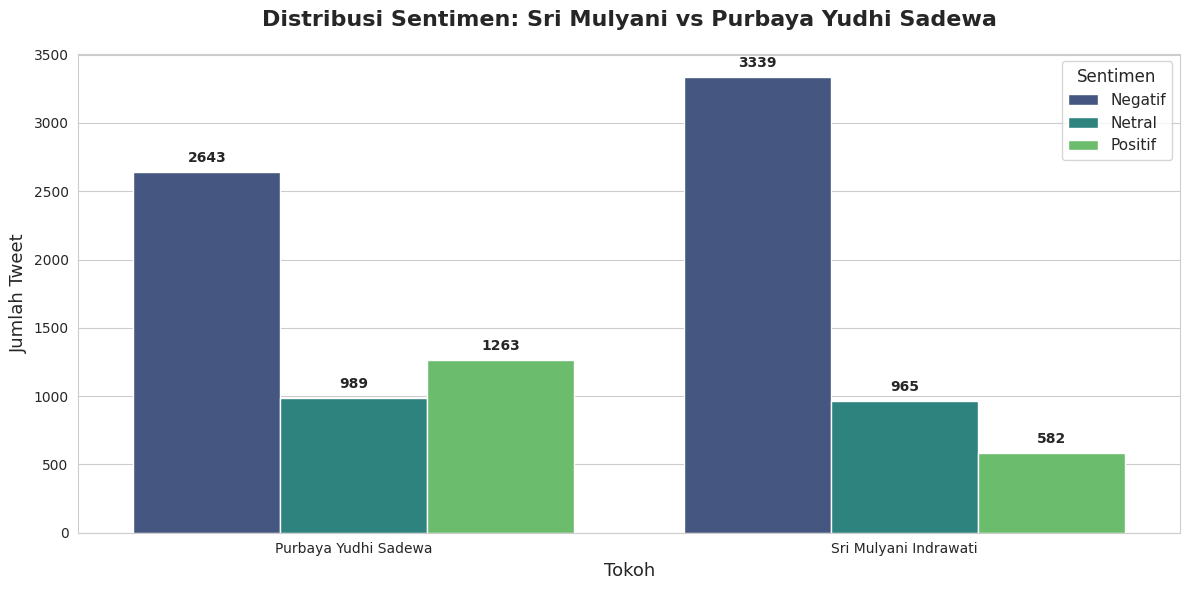


📊 STATISTIK SENTIMEN PER TOKOH:
label_final            Negatif  Netral  Positif
tokoh                                          
Purbaya Yudhi Sadewa      2643     989     1263
Sri Mulyani Indrawati     3339     965      582

📈 Persentase:
label_final            Negatif  Netral  Positif
tokoh                                          
Purbaya Yudhi Sadewa      54.0    20.2     25.8
Sri Mulyani Indrawati     68.3    19.8     11.9


In [ ]:
# ============================================
# CELL 10: VISUALISASI 1 - DISTRIBUSI SENTIMEN
# ============================================
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df, x='tokoh', hue='label_final', palette='viridis')

plt.title('Distribusi Sentimen: Sri Mulyani vs Purbaya Yudhi Sadewa',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Tokoh', fontsize=13)
plt.ylabel('Jumlah Tweet', fontsize=13)
plt.legend(title='Sentimen', fontsize=11, title_fontsize=12)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}',
                    xy=(p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    xytext=(0, 5), textcoords='offset points',
                    fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Statistik detail
print("\n📊 STATISTIK SENTIMEN PER TOKOH:")
print("=" * 60)
sentiment_stats = df.groupby(['tokoh', 'label_final']).size().unstack(fill_value=0)
print(sentiment_stats)
print("\n📈 Persentase:")
print(sentiment_stats.div(sentiment_stats.sum(axis=1), axis=0).round(3) * 100)


🎨 WORDCLOUD - ISU DOMINAN


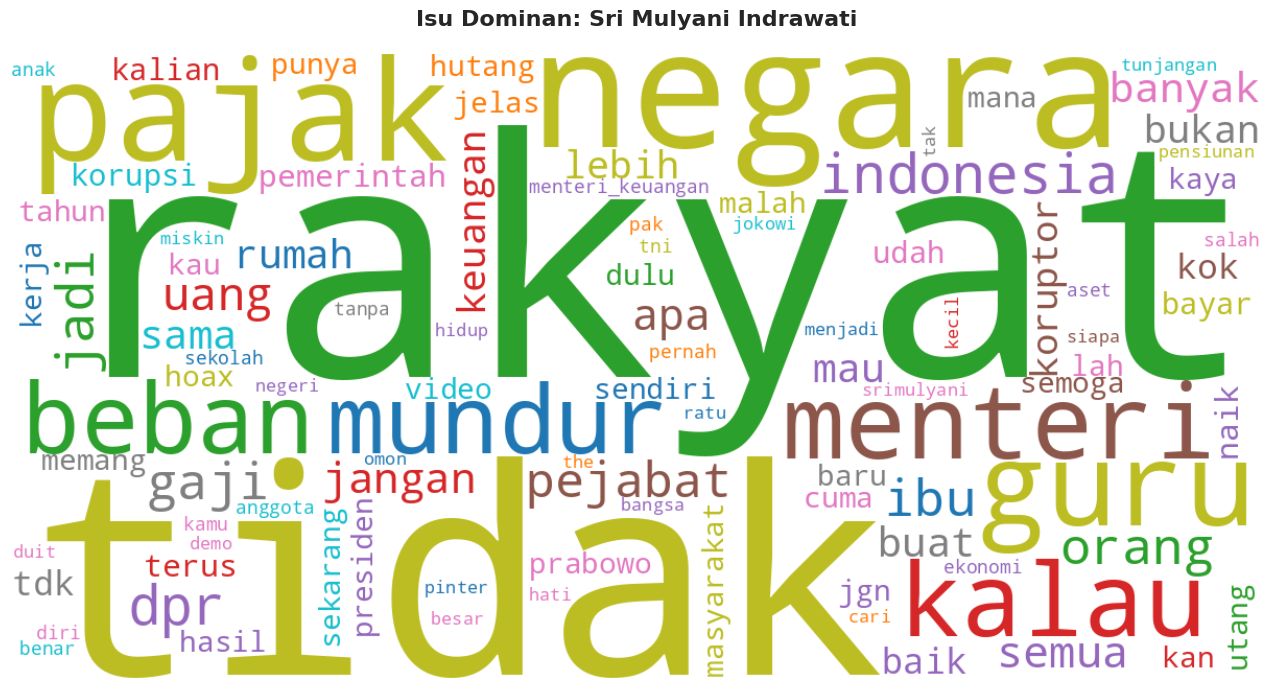

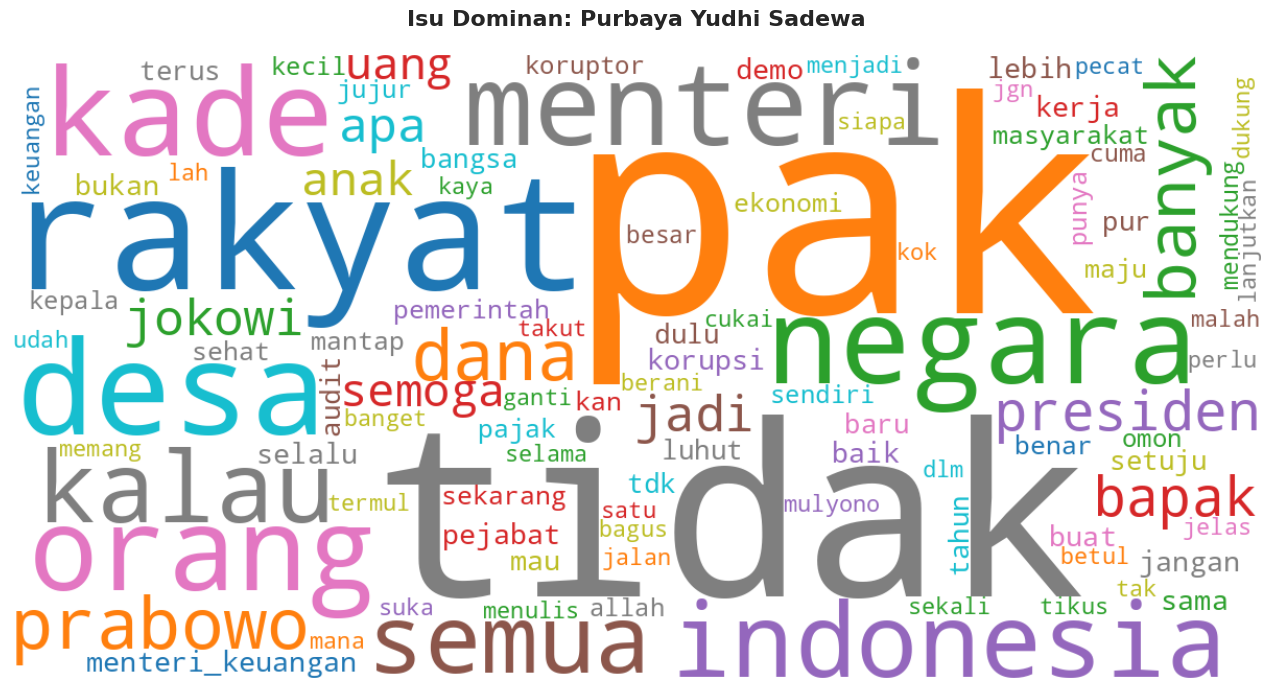

In [ ]:
# ============================================
# CELL 11: VISUALISASI 2 - WORDCLOUD (CLEAN)
# ============================================
def generate_wordcloud_clean(nama_tokoh, sentimen=None):
    """Generate WordCloud dari clean_no_emoji (tanpa kata emoji)"""

    mask = df['tokoh'] == nama_tokoh
    if sentimen:
        mask = mask & (df['label_final'] == sentimen)

    subset = df[mask]['clean_no_emoji'].dropna()

    if len(subset) == 0:
        print(f"⚠️ Tidak ada data untuk {nama_tokoh} - {sentimen}")
        return

    text_data = ' '.join(subset)

    # Stopwords tambahan (hilangkan nama tokoh dari wordcloud)
    stopwords_viz = final_stopwords | {
        'sri', 'mulyani', 'purbaya', 'yudhi', 'sadewa'
    }

    wc = WordCloud(
        width=1200,
        height=600,
        background_color='white',
        colormap='tab10',
        max_words=100,
        stopwords=stopwords_viz,
        collocations=False,
        relative_scaling=0.5,
        min_font_size=10
    ).generate(text_data)

    plt.figure(figsize=(14, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')

    title = f'Isu Dominan: {nama_tokoh}'
    if sentimen:
        title += f' ({sentimen})'
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

print("\n🎨 WORDCLOUD - ISU DOMINAN")
print("=" * 60)

generate_wordcloud_clean('Sri Mulyani Indrawati')
generate_wordcloud_clean('Purbaya Yudhi Sadewa')



📊 N-GRAM ANALYSIS - ISU UTAMA

🔹 BIGRAM (2 kata):


/tmp/ipython-input-3925340458.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


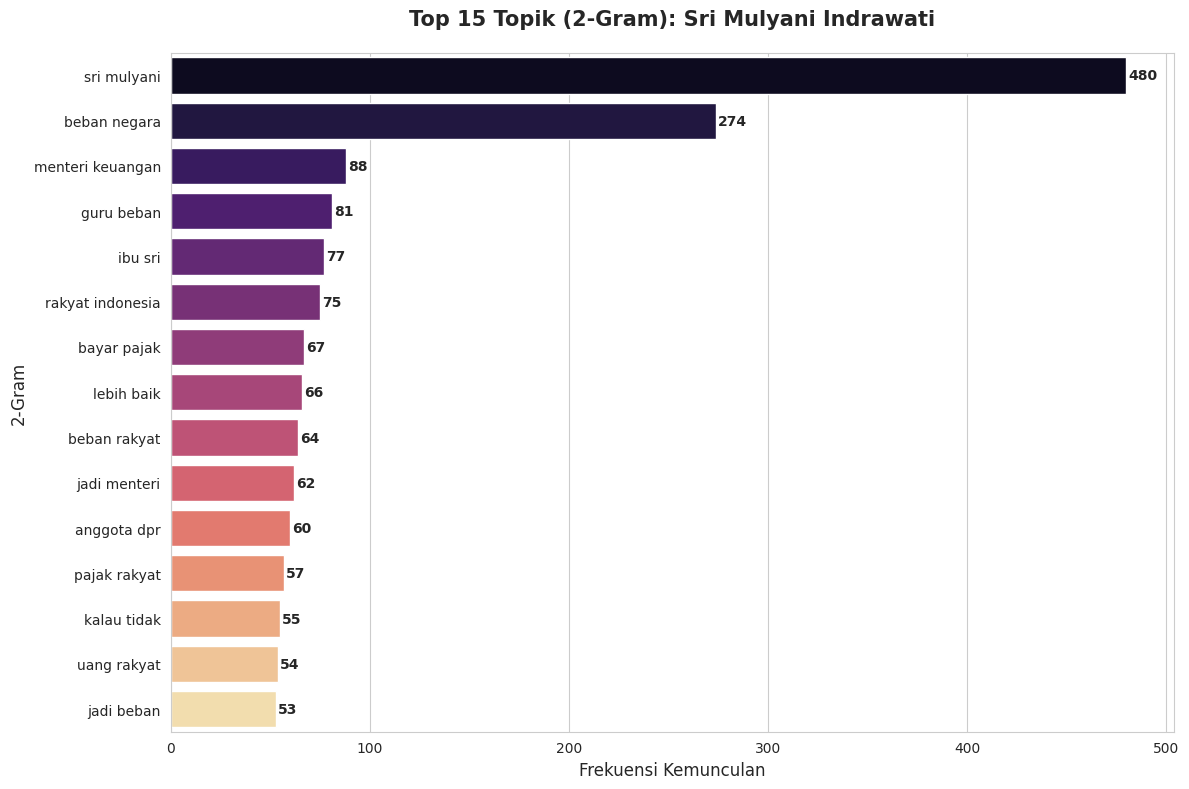

/tmp/ipython-input-3925340458.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


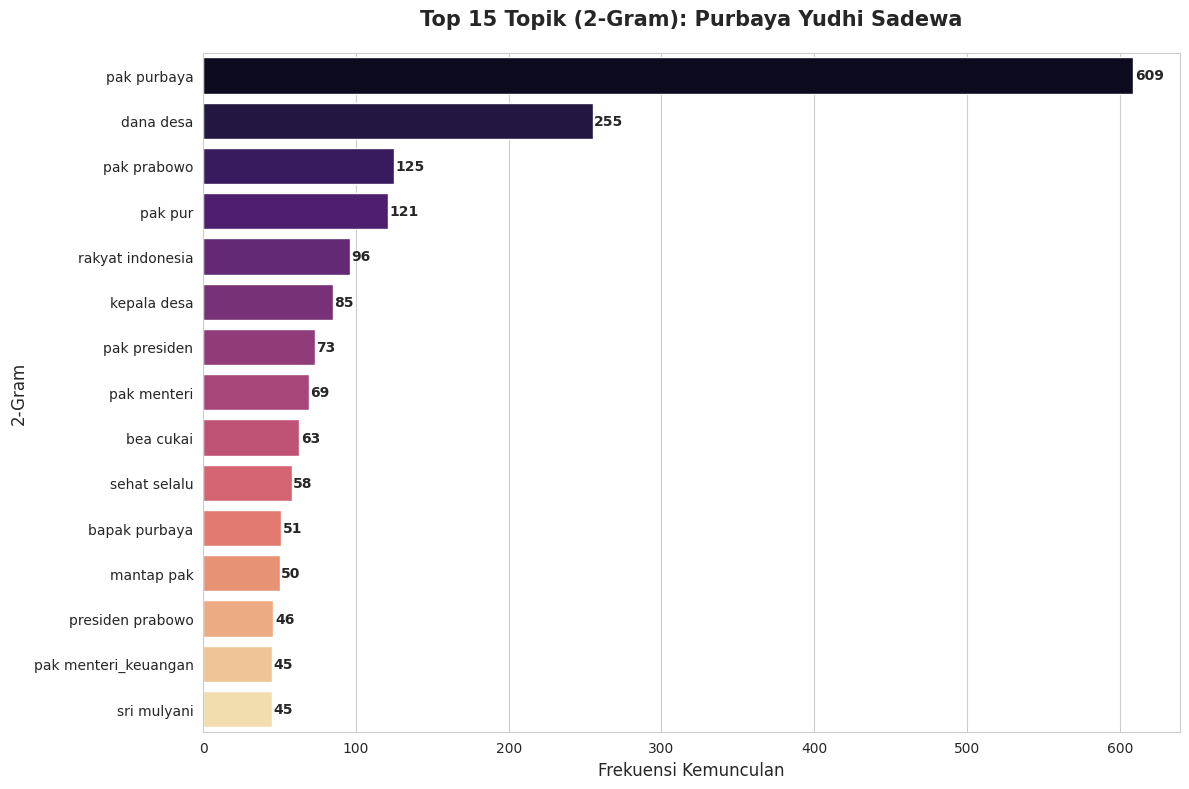


🔹 TRIGRAM (3 kata):


/tmp/ipython-input-3925340458.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


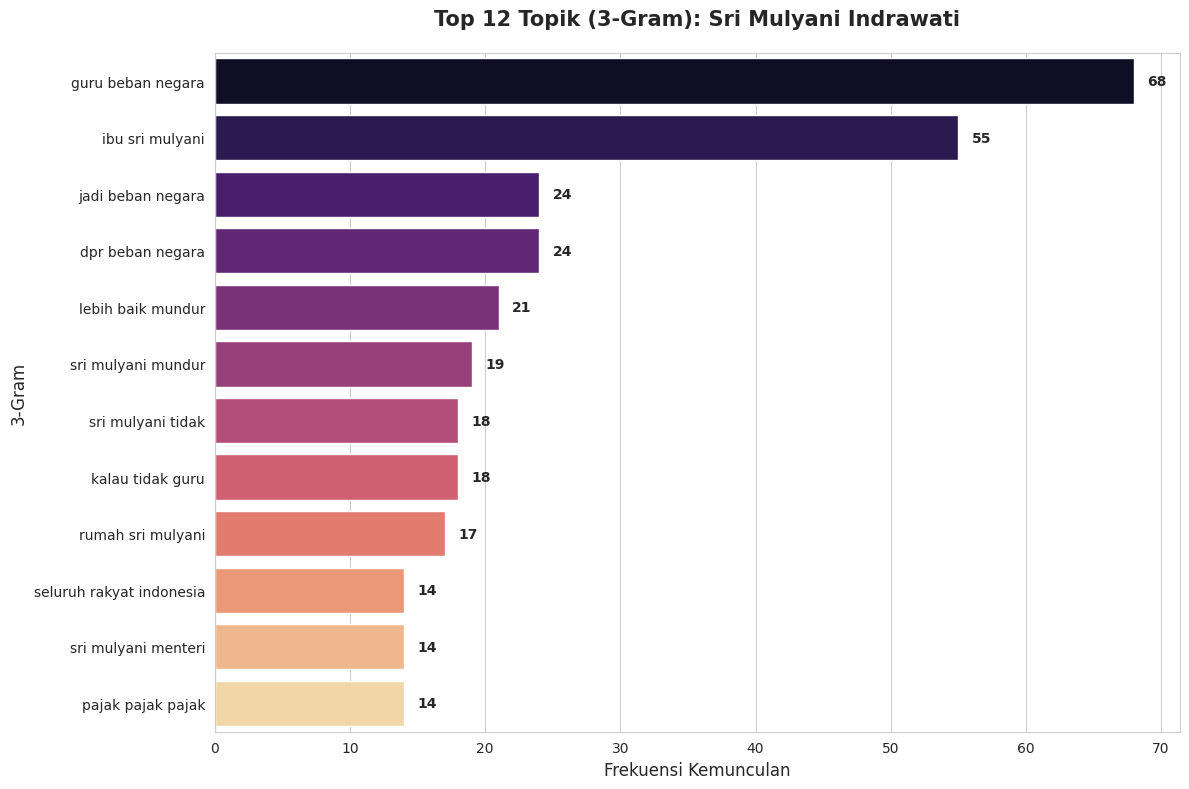

/tmp/ipython-input-3925340458.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


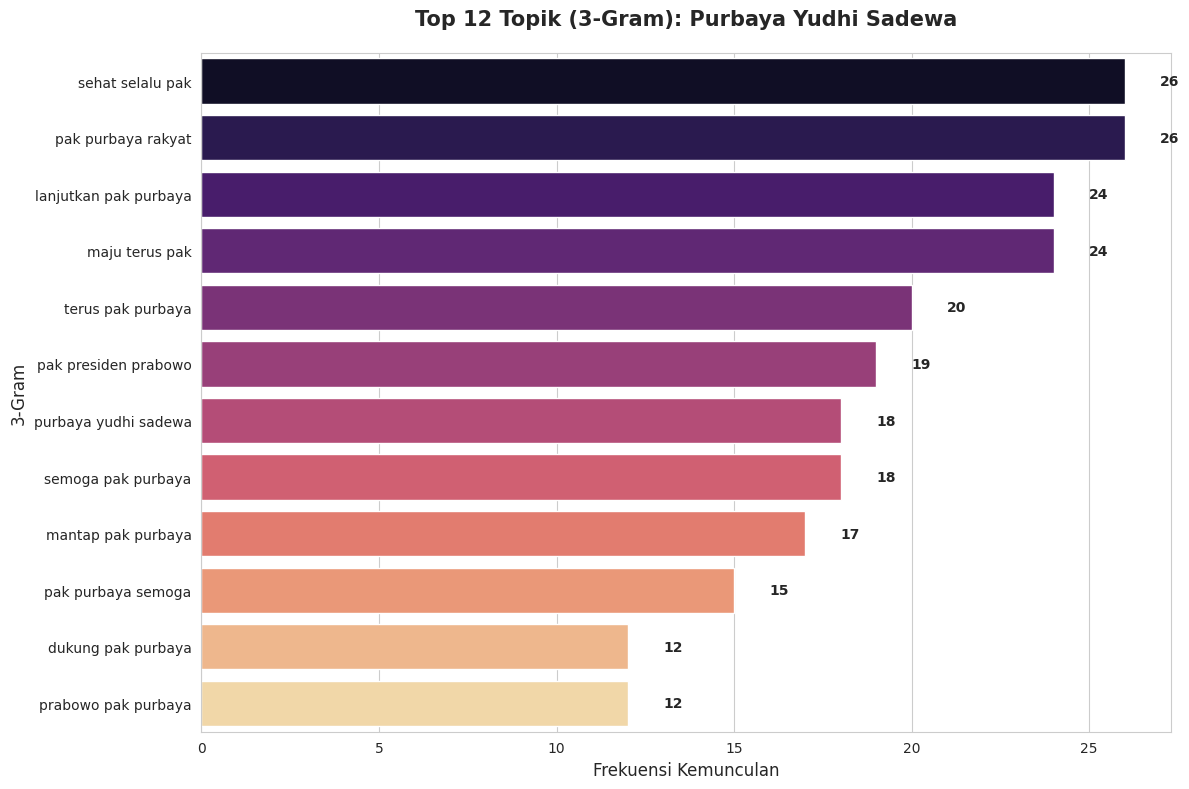

In [ ]:
# ============================================
# CELL 12: VISUALISASI 3 - N-GRAM (CLEAN)
# ============================================
def plot_ngram_optimized(nama_tokoh, n=2, sentimen=None, top_n=15):
    """Plot N-Gram dari clean_no_emoji (bebas dari kata emoji)"""

    mask = df['tokoh'] == nama_tokoh
    if sentimen:
        mask = mask & (df['label_final'] == sentimen)

    subset = df[mask]['clean_no_emoji'].dropna()

    if len(subset) == 0:
        print(f"⚠️ Tidak ada data untuk {nama_tokoh}")
        return

    # Stopwords untuk N-Gram
    ngram_stopwords = list(final_stopwords)

    try:
        vectorizer = CountVectorizer(
            ngram_range=(n, n),
            stop_words=ngram_stopwords,
            max_features=500,
            min_df=2
        )

        ngrams = vectorizer.fit_transform(subset)
        freq = ngrams.toarray().sum(axis=0)
        vocab = vectorizer.vocabulary_

        df_ngram = pd.DataFrame([
            (freq[idx], word)
            for word, idx in vocab.items()
        ], columns=['frequency', 'ngram'])

        df_ngram = df_ngram.sort_values('frequency', ascending=False).head(top_n)

        if len(df_ngram) == 0:
            print(f"⚠️ Tidak ada {n}-gram yang valid")
            return

        # Plot
        plt.figure(figsize=(12, 8))
        colors = sns.color_palette('magma', len(df_ngram))

        ax = sns.barplot(
            data=df_ngram,
            y='ngram',
            x='frequency',
            palette=colors,
            orient='h'
        )

        title = f'Top {top_n} Topik ({n}-Gram): {nama_tokoh}'
        if sentimen:
            title += f' - {sentimen}'

        plt.title(title, fontsize=15, fontweight='bold', pad=20)
        plt.xlabel('Frekuensi Kemunculan', fontsize=12)
        plt.ylabel(f'{n}-Gram', fontsize=12)

        for i, (idx, row) in enumerate(df_ngram.iterrows()):
            ax.text(row['frequency'] + 1, i, f"{int(row['frequency'])}",
                   va='center', fontsize=10, fontweight='bold')

        plt.tight_layout()
        plt.show()

    except ValueError as e:
        print(f"❌ Error: {e}")

print("\n📊 N-GRAM ANALYSIS - ISU UTAMA")
print("=" * 60)

# Bigram
print("\n🔹 BIGRAM (2 kata):")
plot_ngram_optimized('Sri Mulyani Indrawati', n=2, top_n=15)
plot_ngram_optimized('Purbaya Yudhi Sadewa', n=2, top_n=15)

# Trigram
print("\n🔹 TRIGRAM (3 kata):")
plot_ngram_optimized('Sri Mulyani Indrawati', n=3, top_n=12)
plot_ngram_optimized('Purbaya Yudhi Sadewa', n=3, top_n=12)


😊 ANALISIS PENGGUNAAN EMOJI


/tmp/ipython-input-1592525209.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_emoji, x='count', y='emoji', palette='viridis')


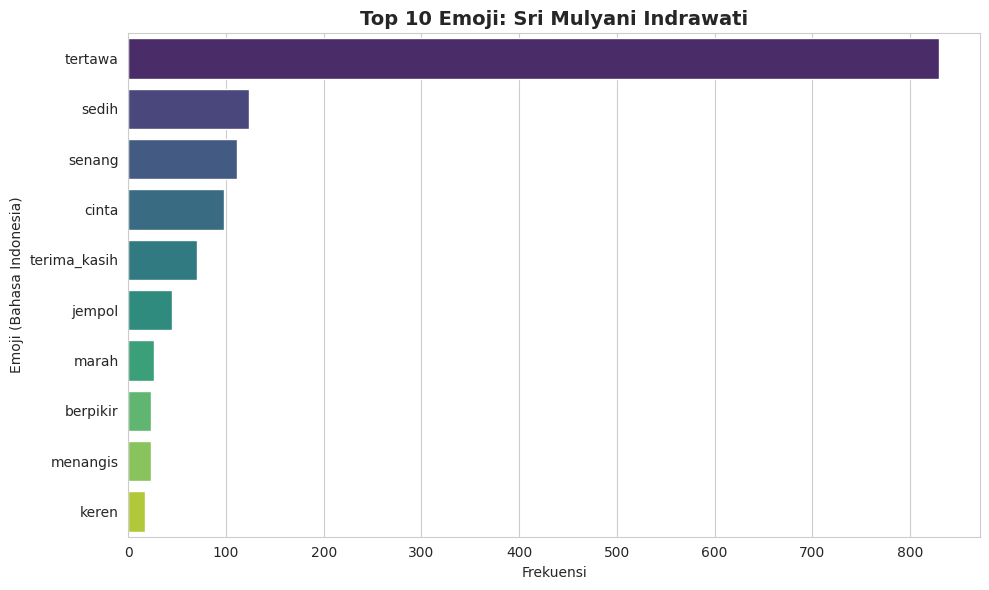

/tmp/ipython-input-1592525209.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_emoji, x='count', y='emoji', palette='viridis')


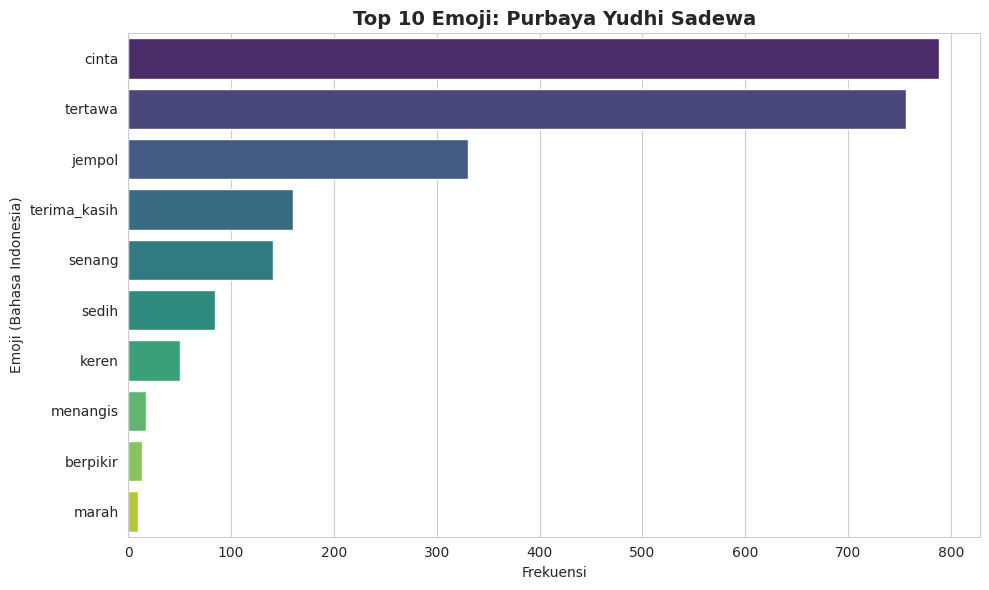

In [ ]:
# ============================================
# CELL 13: ANALISIS EMOJI USAGE
# ============================================
print("\n😊 ANALISIS PENGGUNAAN EMOJI")
print("=" * 60)

# Flatten emoji list
from collections import Counter

def get_top_emojis(nama_tokoh, top_n=10):
    """Analisis emoji paling sering digunakan per tokoh"""
    subset = df[df['tokoh'] == nama_tokoh]

    # Flatten list of lists
    all_emojis = []
    for emoji_list in subset['emoji_list']:
        all_emojis.extend(emoji_list)

    if len(all_emojis) == 0:
        print(f"⚠️ Tidak ada emoji untuk {nama_tokoh}")
        return

    # Count frequency
    emoji_counts = Counter(all_emojis)
    top_emojis = emoji_counts.most_common(top_n)

    # Plot
    df_emoji = pd.DataFrame(top_emojis, columns=['emoji', 'count'])

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_emoji, x='count', y='emoji', palette='viridis')
    plt.title(f'Top {top_n} Emoji: {nama_tokoh}', fontsize=14, fontweight='bold')
    plt.xlabel('Frekuensi')
    plt.ylabel('Emoji (Bahasa Indonesia)')
    plt.tight_layout()
    plt.show()

    return df_emoji

# Analisis per tokoh
emoji_sri = get_top_emojis('Sri Mulyani Indrawati', top_n=10)
emoji_purbaya = get_top_emojis('Purbaya Yudhi Sadewa', top_n=10)


🔗 KORELASI: Emoji Sentiment Score vs Label Sentimen

📋 Classification Report (Emoji-based Prediction):


/tmp/ipython-input-174656478.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['emoji_predicted_sentiment'] = df['emoji_sentiment'].apply(emoji_to_sentiment)


              precision    recall  f1-score   support

     Negatif       0.70      0.13      0.22       714
      Netral       0.25      0.03      0.05       280
     Positif       0.31      0.95      0.47       399

    accuracy                           0.35      1393
   macro avg       0.42      0.37      0.25      1393
weighted avg       0.50      0.35      0.26      1393



/tmp/ipython-input-174656478.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label_numeric'] = df['label_final'].map(sentiment_mapping)


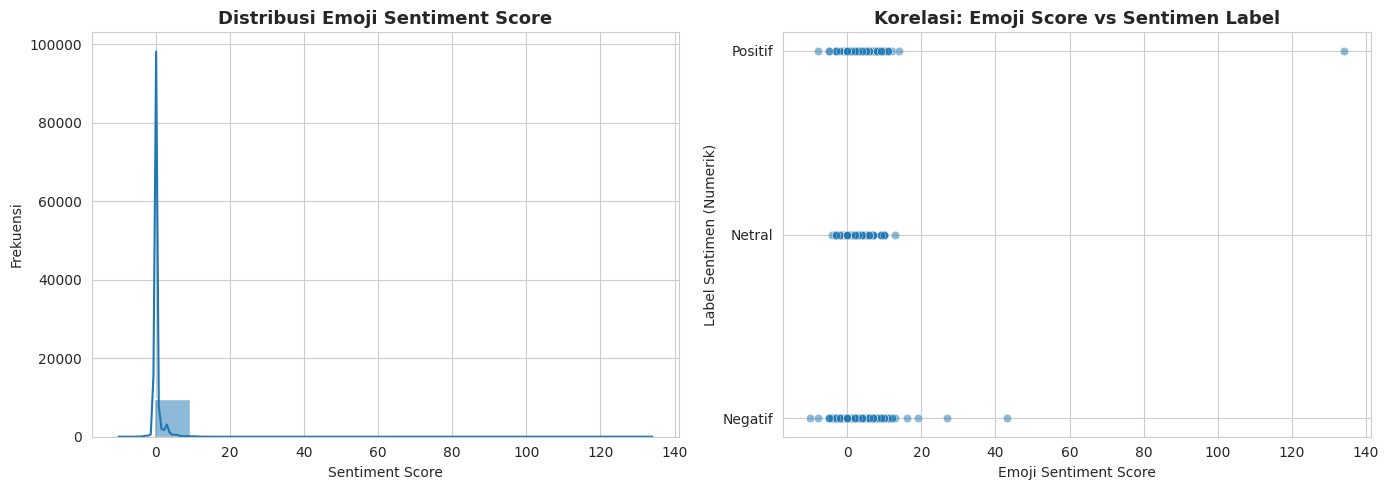

In [ ]:
# ============================================
# CELL 14: KORELASI EMOJI vs SENTIMEN LABEL
# ============================================
print("\n🔗 KORELASI: Emoji Sentiment Score vs Label Sentimen")
print("=" * 60)

# Hitung akurasi prediksi emoji
def emoji_to_sentiment(score):
    if score > 0:
        return 'Positif'
    elif score < 0:
        return 'Negatif'
    else:
        return 'Netral'

df['emoji_predicted_sentiment'] = df['emoji_sentiment'].apply(emoji_to_sentiment)

# Confusion matrix sederhana
from sklearn.metrics import classification_report

# Filter hanya yang punya emoji
df_with_emoji = df[df['emoji_list'].apply(len) > 0]

if len(df_with_emoji) > 0:
    print("\n📋 Classification Report (Emoji-based Prediction):")
    print(classification_report(
        df_with_emoji['label_final'],
        df_with_emoji['emoji_predicted_sentiment'],
        zero_division=0
    ))

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Distribusi Emoji Sentiment Score
sns.histplot(data=df, x='emoji_sentiment', bins=15, kde=True, ax=axes[0])
axes[0].set_title('Distribusi Emoji Sentiment Score', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Sentiment Score')
axes[0].set_ylabel('Frekuensi')

# Plot 2: Korelasi dengan Label Asli
sentiment_mapping = {'Positif': 1, 'Netral': 0, 'Negatif': -1}
df['label_numeric'] = df['label_final'].map(sentiment_mapping)

sns.scatterplot(data=df, x='emoji_sentiment', y='label_numeric',
                alpha=0.5, ax=axes[1])
axes[1].set_title('Korelasi: Emoji Score vs Sentimen Label', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Emoji Sentiment Score')
axes[1].set_ylabel('Label Sentimen (Numerik)')
axes[1].set_yticks([-1, 0, 1])
axes[1].set_yticklabels(['Negatif', 'Netral', 'Positif'])

plt.tight_layout()
plt.show()

In [ ]:

# ============================================
# CELL 15: SAVE HASIL
# ============================================
# Simpan dataset lengkap
output_path = '/content/drive/MyDrive/Dataset purbaya seri/hasil_preprocessing_final.csv'
df.to_csv(output_path, index=False)
print(f"\n💾 Dataset tersimpan: {output_path}")

# Simpan summary emoji
emoji_summary = pd.DataFrame({
    'Sri Mulyani': emoji_sri['emoji'].tolist() if emoji_sri is not None else [],
    'Purbaya': emoji_purbaya['emoji'].tolist() if emoji_purbaya is not None else []
})
emoji_summary.to_csv('/content/drive/MyDrive/Dataset purbaya seri/emoji_summary.csv', index=False)

print("\n✅ PREPROCESSING SELESAI!")
print("=" * 60)
print(f"📊 Total data: {len(df)} rows")
print(f"📂 Kolom yang tersimpan:")
print("   - text (original)")
print("   - emoji_list (emoji translated ke Indo)")
print("   - emoji_sentiment (sentiment score dari emoji)")
print("   - clean_with_emoji (text + emoji translated)")
print("   - clean_no_emoji (text tanpa emoji - untuk visualisasi)")
print("   - clean_stemmed (text stemmed untuk modeling)")
print("\n🎯 Siap untuk tahap modeling!")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import chi2_contingency
import re

# --- 0. Persiapan Data (Pastikan df sudah terload) ---
# Jika df belum ada, uncomment baris bawah dan sesuaikan nama file
# df = pd.read_csv('hasil_labelling_final_filtered.csv')

# Fungsi cleaning sederhana untuk visualisasi (jika kolom text_clean tidak tersimpan)


def simple_clean(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Hapus non-huruf
    # Tambahkan stopwords manual sederhana jika perlu
    stopwords = ['yg', 'dan', 'di', 'ke', 'ini', 'itu', 'adalah',
                 'saya', 'tidak', 'tapi', 'kalau', 'yang', 'ada', 'untuk']
    return ' '.join([w for w in text.split() if w not in stopwords])


# Gunakan kolom ini untuk wordcloud
df['text_viz'] = df['text'].apply(simple_clean)

# --- A. ANALISIS GRANULAR: WORD CLOUD PER TOKOH & SENTIMEN ---


def plot_wordcloud(tokoh, sentimen, ax):
    subset = df[(df['tokoh'] == tokoh) & (df['label_final'] == sentimen)]
    text = ' '.join(subset['text_viz'])

    if not text:
        return  # Skip jika data kosong

    wc = WordCloud(width=800, height=400, background_color='white',
                   colormap='viridis').generate(text)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"{tokoh} - {sentimen}")


fig, axes = plt.subplots(2, 2, figsize=(16, 10))
# Baris 1: Purbaya (Positif & Negatif)
plot_wordcloud('Purbaya Yudhi Sadewa', 'Positif', axes[0, 0])
plot_wordcloud('Purbaya Yudhi Sadewa', 'Negatif', axes[0, 1])
# Baris 2: Sri Mulyani (Positif & Negatif)
plot_wordcloud('Sri Mulyani Indrawati', 'Positif', axes[1, 0])
plot_wordcloud('Sri Mulyani Indrawati', 'Negatif', axes[1, 1])

plt.tight_layout()
plt.show()

# --- B. ANALISIS N-GRAM (Top 2 Kata yang sering muncul bersama) ---


def get_top_ngrams(corpus, n=2, top_k=10):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]


# Contoh: Melihat frase apa yang sering muncul di sentimen Negatif Sri Mulyani
print("Top 5 Frase (Bigram) di Sentimen Negatif Sri Mulyani:")
neg_sm = df[(df['tokoh'] == 'Sri Mulyani Indrawati') &
            (df['label_final'] == 'Negatif')]['text_viz']
print(get_top_ngrams(neg_sm, n=2, top_k=5))

# --- C. UJI SIGNIFIKANSI STATISTIK (Chi-Square) ---
# Membuat tabel kontingensi (Cross-tabulation)
contingency_table = pd.crosstab(df['tokoh'], df['label_final'])
print("\nTabel Kontingensi:")
print(contingency_table)

# Menghitung Chi-Square
stat, p, dof, expected = chi2_contingency(contingency_table)

print(f"\nNilai P-Value: {p:.5f}")
alpha = 0.05
if p < alpha:
    print("KESIMPULAN: Terdapat perbedaan yang SIGNIFIKAN secara statistik antara sentimen Purbaya dan Sri Mulyani.")
    print("Artinya: Perbedaan sentimen ini bukan kebetulan, melainkan benar-benar ada pola yang berbeda di masyarakat.")
else:
    print("KESIMPULAN: TIDAK terdapat perbedaan signifikan (perbedaan mungkin karena kebetulan).")